<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/notebooks/Result_Visulization2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Result Visulization (결과 시각화)

# 1. Library Import

In [138]:
import os, matplotlib, csv, shutil, json
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import Image
from tqdm import tqdm

import skimage
from skimage import transform as skit
from skimage import filters as skif

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 2. 데이터셋 로딩

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 16s 0us/step


In [3]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# 2.1 Cifar10 to Cifar2 (airplane, automobile)

In [4]:
x_train_list, y_train_list = [], []
x_test_list, y_test_list = [], []
n0, n1 = 0, 0
t0, t1 = 0, 0
for i, i_ in enumerate(x_train):
  if y_train[i] == 0 and n0 < 500:
    arr = skit.resize(i_, (64, 64), anti_aliasing=True)
    onehot = [1, 0]
    n0 += 1
    x_train_list.append(arr)
    y_train_list.append(onehot)
  elif y_train[i] == 1 and n1 < 500:
    arr = skit.resize(i_, (64, 64), anti_aliasing=True)
    onehot = [0, 1]
    n1 += 1
    x_train_list.append(arr)
    y_train_list.append(onehot)
for i, i_ in enumerate(x_test):
    if y_test[i] == 0 and t0 < 100:
      arr = skit.resize(i_, (64, 64), anti_aliasing=True)
      onehot = [1, 0]
      t0 += 1
      x_test_list.append(arr)
      y_test_list.append(onehot)
    elif y_test[i] == 1 and t1 < 100:
      arr = skit.resize(i_, (64, 64), anti_aliasing=True)
      onehot = [0, 1]
      t1 += 1
      x_test_list.append(arr)
      y_test_list.append(onehot)

train_x = np.array(x_train_list)
train_y = np.array(y_train_list)
print(train_x.shape, train_y.shape)
test_x = np.array(x_test_list)
test_y = np.array(y_test_list)
print(test_x.shape, test_y.shape)

(1000, 64, 64, 3) (1000, 2)
(200, 64, 64, 3) (200, 2)


## 2.2 Cifar2 figure

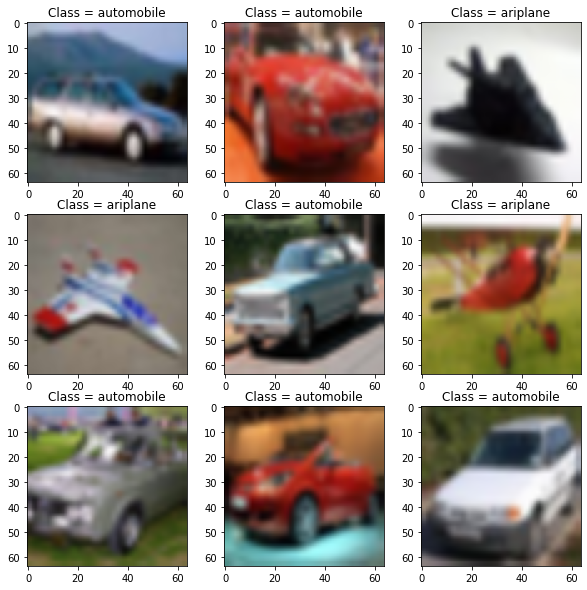

In [5]:
label_list = ['ariplane', 'automobile']
plt.figure(figsize=(10,10))
num = 3
for i in range(num):
    for j in range(num):
      id = (num*i) + j
      plt.subplot(num,num,id+1)
      plt.imshow(train_x[id])
      plt.title('Class = {}'.format(label_list[list(train_y[id]).index(1)]))

# 3. VGG Model Build

In [6]:
def conv_block_2d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filter_num, conv_size, activation=None, padding='same', 
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def output_block(lr_dense, block_num, dens_count, act_func, drop_rate):
    lr_dense = layers.Flatten(name='flatten_layer')(lr_dense)
    for i in range(block_num):
        lr_dense = layers.Dense(dens_count[i], kernel_regularizer=None,
                                activation=act_func, name='classifier_dense_{}'.format(i+1))(lr_dense)
        lr_dense = layers.Dropout(drop_rate, name='classifier_dropout_{}'.format(i+1))(lr_dense)
    return lr_dense

In [7]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    channels = par_dic['channels']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, channels), name='input_layer')
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 3, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 3, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 3, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

In [8]:
def VGG19_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    channels = par_dic['channels']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, channels))
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 4, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 4, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 4, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

In [9]:
network_param_set = {'input_size': 64,
                     'channels': 3,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 2,
                     'output_act': 'softmax'}

In [10]:
model = VGG16_2D(network_param_set)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_batchnorm1 (BatchNor  (None, 64, 64, 64)       256       
 malization)                                                     
                                                                 
 block1_activ1 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_batchnorm2 (BatchNor  (None, 64, 64, 64)       256       
 malization)                                                 

# 4. MNIST Training

In [11]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-4), metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('model.h5'),
                                                         monitor='val_loss', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

history = model.fit(train_x, train_y, epochs=50, batch_size=20, 
                    validation_data=(test_x, test_y),
                    callbacks=callback_list, shuffle=True)

Epoch 1/50
50/50 [==============================] - 13s 66ms/step - loss: 1.0510 - accuracy: 0.6220 - val_loss: 0.8682 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 2s 48ms/step - loss: 0.4851 - accuracy: 0.8100 - val_loss: 1.6846 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - 2s 48ms/step - loss: 0.3960 - accuracy: 0.8510 - val_loss: 2.4516 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
50/50 [==============================] - 2s 48ms/step - loss: 0.3140 - accuracy: 0.8660 - val_loss: 1.7433 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/50
50/50 [==============================] - 2s 49ms/step - loss: 0.1883 - accuracy: 0.9210 - val_loss: 1.2844 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 6/50
50/50 [==============================] - 2s 49ms/step - loss: 0.1486 - accuracy: 0.9510 - val_loss: 0.9336 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 7/50
50/50 [==============================] -

# 5. Train Result

## 5.1. Loss & Accuracy

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

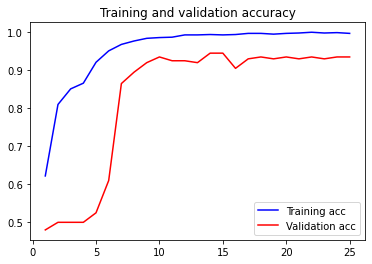

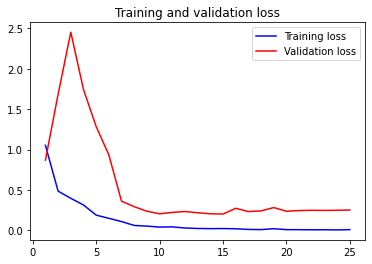

In [14]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##5.2. Prediction Result

(64, 64, 3)


Text(0.5, 1.0, 'ariplane')

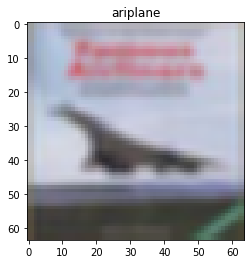

In [15]:
test1 = test_x[0]
print(test1.shape)
plt.imshow(test1)
plt.title(label_list[list(test_y[0]).index(1)])

In [16]:
scores = model.predict(test_x)

new_scores = []
for score in scores:
  max_val = np.max(score)
  prob_num = label_list[list(score).index(max_val)]
  new_scores.append(prob_num)
print(new_scores)

7/7 [==============================] - 2s 64ms/step
['ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'ariplane', 'automobile', 'automobile', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'automobile', 'ariplane', 'automobile', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'automobile', 'automobile', '

In [17]:
new_labels = []
for y in test_y:
  max_val = np.max(y)
  prob_num = label_list[list(y).index(max_val)]
  new_labels.append(prob_num)
print(new_labels)

['ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'ariplane', 'automobile', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane', 'automobile', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'ariplane', 'automobile', 'ariplane', 'ariplane', 'automobile', 'automobile', 'automobile', 'ariplane', 'ariplane', 'ariplane', 'automobile', 'ariplane

label=ariplane, predict=ariplane
[0.997399   0.00260103]


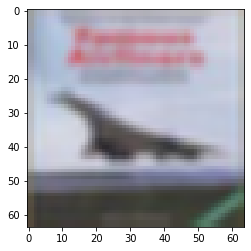

In [18]:
plt.imshow(test_x[0])
print(f'label={label_list[list(test_y[0]).index(1)]}, predict={new_scores[0]}')
print(scores[0])


### 5.3. Confusion Matrix

In [19]:
conf = confusion_matrix(new_labels, new_scores, labels=label_list)
print(conf)

[[92  8]
 [ 5 95]]


[Text(0, 0.5, 'ariplane'), Text(0, 1.5, 'automobile')]

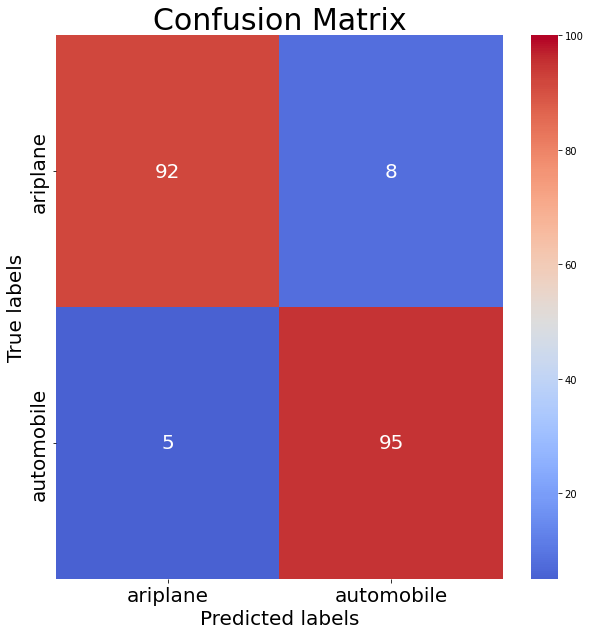

In [20]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf, annot = True, cmap="coolwarm", vmax = 100, 
                 annot_kws={"fontsize":20}, center=50, cbar=True, 
                 xticklabels=label_list, yticklabels=label_list)

# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize=20);ax.set_ylabel('True labels',fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=30); 
ax.xaxis.set_ticklabels(label_list, fontsize=20); ax.yaxis.set_ticklabels(label_list, fontsize=20)

# 6. Result Visualization

## 6.1. Class Activation Map

먼저 GRAD-CAM을 구해주는 함수를 정의한다.

In [21]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):

    # 1. 먼저 모델에서 마지막 컨브넷층을 output으로 하고, 테스트 이미지를 input으로 하는 모델을 구성한다.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # 2. 마지막 컨브넷층과 최종 예측결과를 인아웃으로 받는 모델을 구성한다.
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # 그다음, 테스트 이미지에 대한 가장 높은 예측 클래스와 마지막 컨브넷층에 대한 그래디언트를 구한다.
    with tf.GradientTape() as tape:
        # 최종 컨브넷층의 결과 추출
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # 예측 클래스 계산
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # 마지막 컨브넷층의 특성맵에 대한 가장 높은 예측 클래스의 그래디언트.
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 가장 높은 예측 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱한다.
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵.
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # 마지막으로 구해진 히트맵을 0 ~ 1 사이값으로 정규화
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

(1, 64, 64, 3) (8, 8) (4, 4)


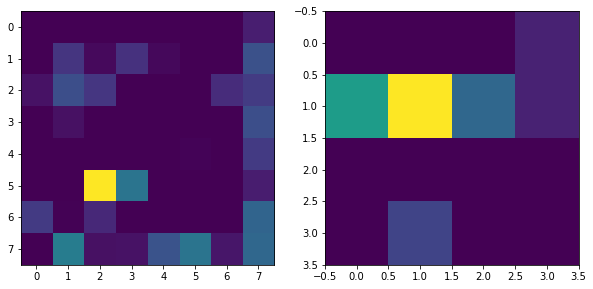

In [98]:
# 테스트 이미지에 대한 히트맵을 구한다.
test1 = np.expand_dims(test_x[0], axis=0)
heatmap1 = make_gradcam_heatmap(test1, model, 'block4_activ3',['block5_pool','flatten_layer'])
heatmap2 = make_gradcam_heatmap(test1, model, 'block5_activ3',['block5_pool','flatten_layer'])
print(test1.shape, heatmap1.shape, heatmap2.shape)

# Display heatmap
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(heatmap1)
plt.subplot(1,2,2)
plt.imshow(heatmap2)

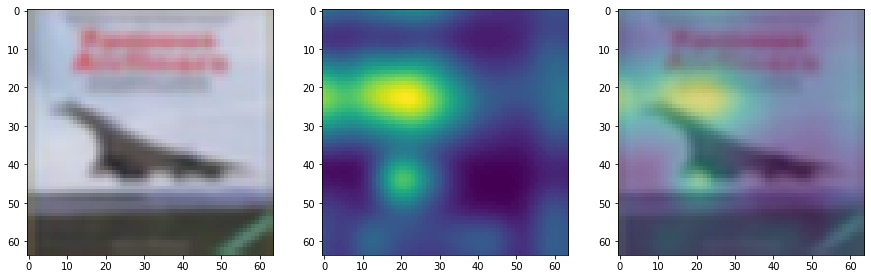

In [99]:
# 원본크기에 맞게 히트맵 변환
hm1 = skit.resize(heatmap1, (64, 64), anti_aliasing=True) 
hm1 = skif.gaussian(hm1, sigma=3)
hm2 = skit.resize(heatmap2, (64, 64), anti_aliasing=True) 
hm2 = skif.gaussian(hm2, sigma=3)
hmn = (hm1+hm2)/2

# 히트맵을 0 ~255 사이 값으로 재조정
heatmap_n = np.uint8(255 * hmn)
test_n = np.uint8(255*test1)

# 결과 시각화
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(test_n[0])
plt.subplot(1,3,2)
plt.imshow(heatmap_n)
plt.subplot(1,3,3)
plt.imshow(test_n[0])
plt.imshow(heatmap_n, alpha=0.5)

### 6.2. CAM 모듈화

In [100]:
def make_gradcam(img_arr):
  img1 = np.expand_dims(img_arr, axis=0)
  hm1 = make_gradcam_heatmap(img1, model, 'block4_activ3',['block5_pool','flatten_layer'])
  hm2 = make_gradcam_heatmap(img1, model, 'block5_activ3',['block5_pool','flatten_layer'])
  
  # 원본크기에 맞게 히트맵 변환
  hm1 = skit.resize(hm1, (64, 64), anti_aliasing=True) 
  hm1 = skif.gaussian(hm1, sigma=3)
  hm2 = skit.resize(hm2, (64, 64), anti_aliasing=True) 
  hm2 = skif.gaussian(hm2, sigma=3)
  hmn = (hm1+hm2)/2

  # 히트맵을 0 ~255 사이 값으로 재조정
  heatmap1 = np.uint8(255 * hmn)
  img1 = np.uint8(255*img1)
  return img1[0], heatmap1

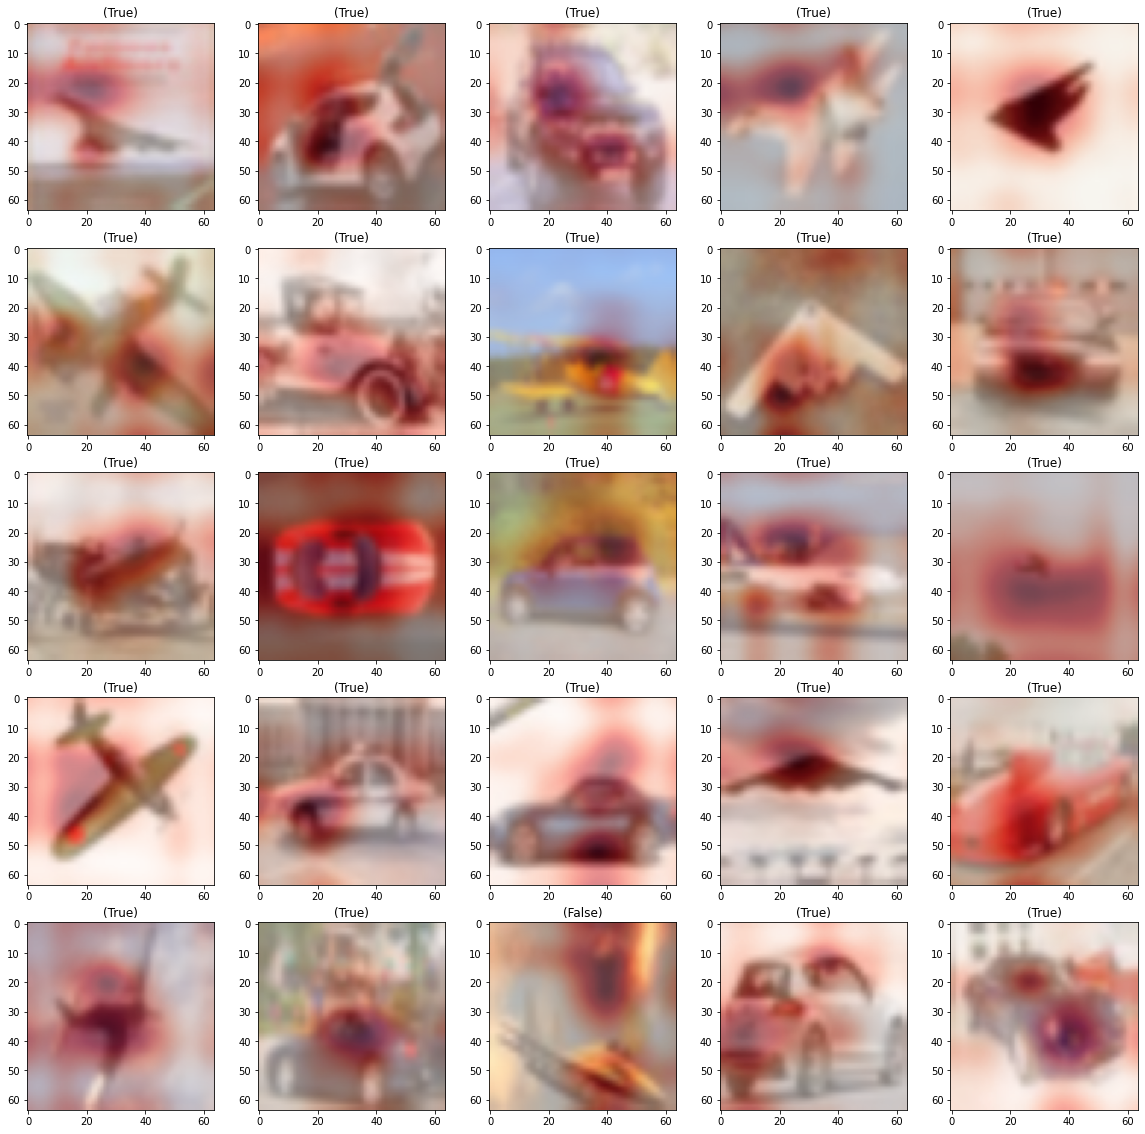

In [120]:
plt.figure(figsize=(20,20))
n,s = 5, 0
for i in range(n):
  for j in range(n):
    img, hm = make_gradcam(test_x[(i*n)+j+s])
    plt.subplot(n,n,(i*n)+j+1)
    plt.imshow(img)
    plt.imshow(hm, alpha=0.5, cmap='Reds')
    if new_scores[(i*n)+j] == new_labels[(i*n)+j]:
      cor = 'True'
    else:
      cor = 'False'
    plt.title(f'({cor})')

## 6.3. Feature Map 시각화

In [102]:
layer_outputs = []
layer_names = []
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)
activation_model = Model(inputs=model.input, outputs=layer_outputs)

(1, 64, 64, 3)


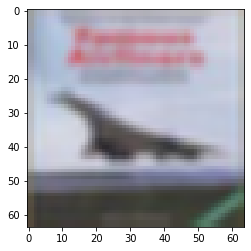

In [104]:
test_img = np.expand_dims(test_x[0], axis=0)
print(test_img.shape)
plt.imshow(test_img[0])

In [105]:
act_result = activation_model.predict(test_img)
print(len(act_result))
for act in act_result:
  print(act.shape)

1/1 [==============================] - 0s 242ms/step
18
(1, 64, 64, 64)
(1, 64, 64, 64)
(1, 32, 32, 64)
(1, 32, 32, 128)
(1, 32, 32, 128)
(1, 16, 16, 128)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 8, 8, 256)
(1, 8, 8, 512)
(1, 8, 8, 512)
(1, 8, 8, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 2, 2, 512)


In [106]:
def show_feature_map(features, all_mode=True):
  plt.figure(figsize=(10,10))
  if all_mode:
    chn = features.shape[-1]
    chns = np.sqrt(chn)
  else:
    chn = 16
    chns = 4
  for i in range(chn):
    plt.subplot(chns, chns, i+1)
    plt.imshow(features[0,...,i])

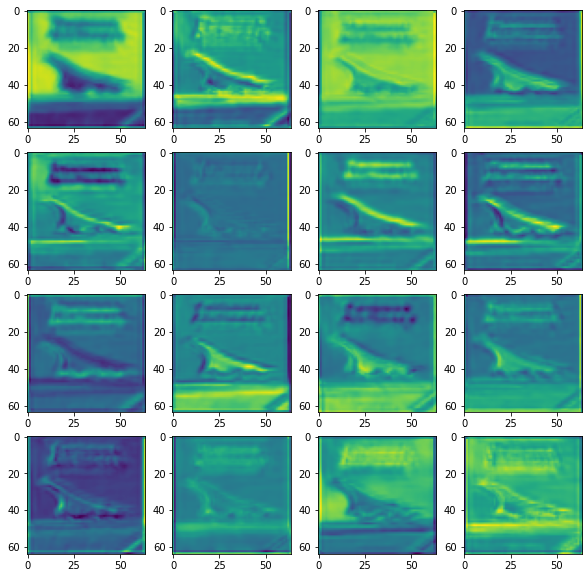

In [110]:
show_feature_map(act_result[1], all_mode=False)

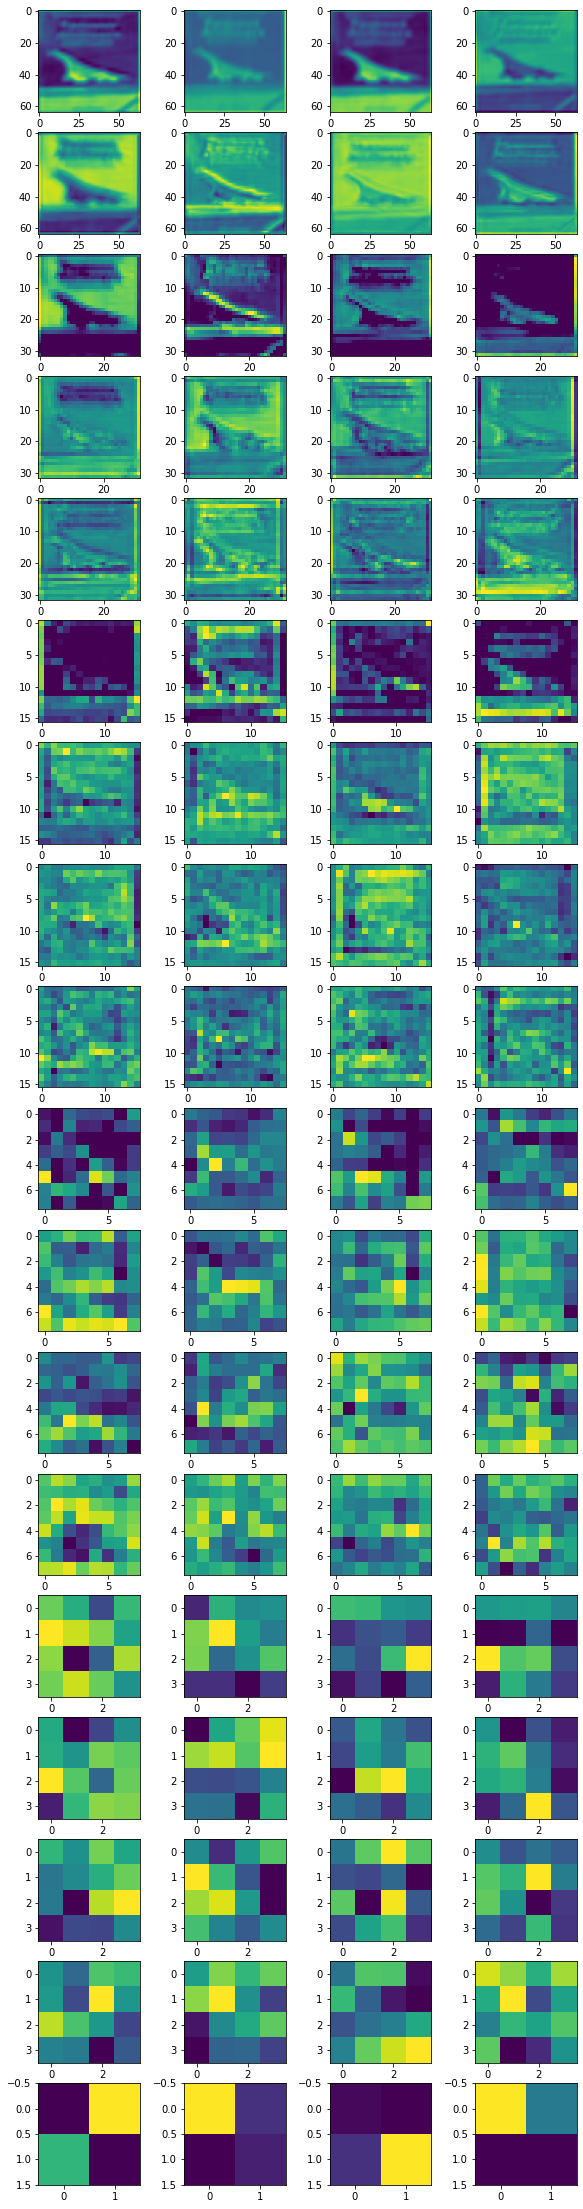

In [119]:
plt.figure(figsize=(10,40))
for i, i_ in enumerate(act_result):
  for j in range(4):
    plt.subplot(len(act_result), 4, (4*i)+j+1)
    plt.imshow(act_result[i][0,...,j])

## 6.4. Filter 시각화

In [133]:
# Gradient 상승법을 사용한 loss function 최대화
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [134]:
# 필터 시각화 함수
def generate_filter_pattern(filter_index, img_width, img_height):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [148]:
def deprocess_image(image, margin):
    image -= np.min(image)
    image /= (np.max(image)-np.min(image))
    image *= 256
    margin = int(image.shape[-2] * margin)
    image = image[margin:-margin, margin:-margin, :]
    return image.astype(np.uint8)

In [149]:
def filter_visual(layer_name):
  layer = model.get_layer(name=layer_name)
  feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

  all_images = []
  for filter_index in tqdm(range(25)):
      image = deprocess_image(generate_filter_pattern(filter_index, 256, 256), 0.1)
      all_images.append(image)

  plt.figure(figsize=(10,10))
  for i in range(5):
    for j in range(5):
      plt.subplot(5,5,(i*5)+j+1)
      plt.imshow(all_images[(i*5)+j])


In [150]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.Activation)):
        print(layer.name)

block1_conv1
block1_activ1
block1_conv2
block1_activ2
block2_conv1
block2_activ1
block2_conv2
block2_activ2
block3_conv1
block3_activ1
block3_conv2
block3_activ2
block3_conv3
block3_activ3
block4_conv1
block4_activ1
block4_conv2
block4_activ2
block4_conv3
block4_activ3
block5_conv1
block5_activ1
block5_conv2
block5_activ2
block5_conv3
block5_activ3


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


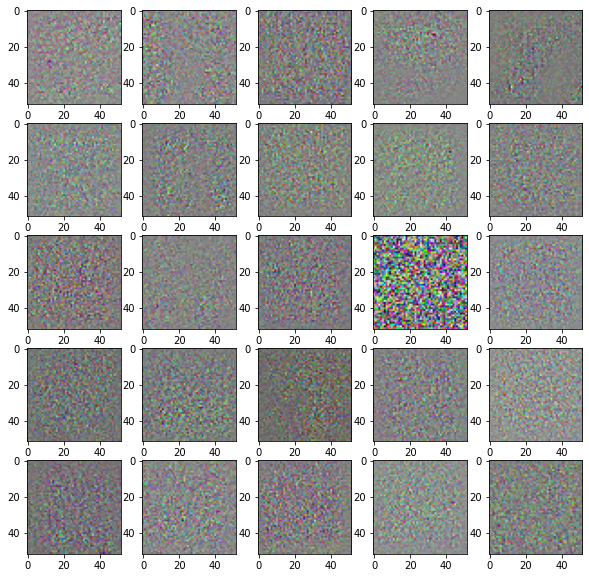

In [154]:
filter_visual('block5_conv1')

In [ ]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)